In [1]:
import numpy as np
import skimage

import matplotlib.pyplot as plt

In [2]:
import skimage.io

f1 = skimage.io.imread('frame1.png')
f2 = skimage.io.imread('frame2.png')

f1.shape, f2.shape

((256, 512), (256, 512))

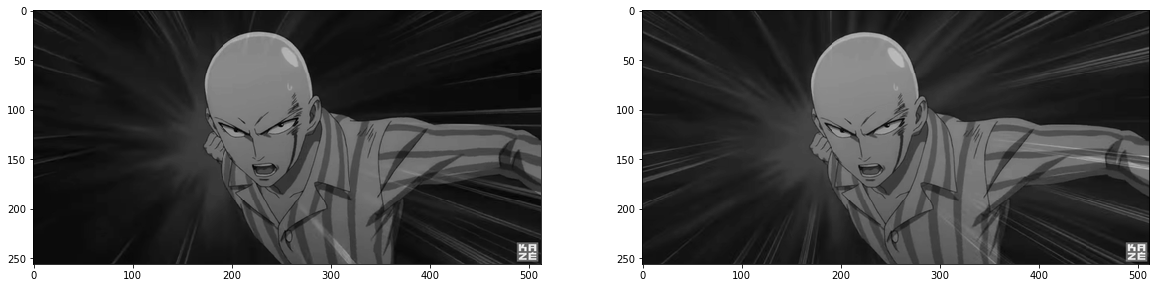

In [3]:
plt.figure(figsize=(20, 9))

plt.subplot(121)
plt.imshow(f1, cmap='gray')

plt.subplot(122)
plt.imshow(f2, cmap='gray')

## Question 1: Motion estimation

### A - Pixel wise method

In [4]:
import progressbar

In [5]:
vxtest = 2
vytest = 1

In [6]:
f1b = f1[0:128,0:128]
f2b = f1[0+vxtest:128+vxtest,0+vytest:128+vytest]


frame_1 = f1b
frame_2 = f2b

def pixel_wise(f1, f2, size_window=8):
    flow = np.zeros(shape=(2, f2.shape[0], f2.shape[1]))
    win = size_window // 2

    ctn = 0

    with progressbar.ProgressBar(max_value=f1.shape[0] * f2.shape[1] * size_window * size_window) as bar:
        for i in range(win, f2.shape[0] - win):
            for j in range(win, f2.shape[1] - win):
                cur = f1[i,j]
                minimal_dist = np.inf
                current_position = (i, j)
                for k in range(i - win, i + win):
                    for l in range(j - win, j + win):
                        dist = np.sqrt((cur - f2[k, l])**2)
                        if (dist < minimal_dist):
                            minimal_dist = dist
                            current_position = (i-k, l-j)
                        bar.update(ctn)
                        ctn += 1
                flow[0, i, j] = current_position[0]
                flow[1, i, j] = current_position[1] 

    return flow

In [7]:
fl = pixel_wise(f1b, f2b)

N/A% (0 of 1048576) |                    | Elapsed Time: 0:00:00 ETA:  --:--:--<ipython-input-6-f9b2c3a948e1>:22: RuntimeWarning: overflow encountered in ushort_scalars
  dist = np.sqrt((cur - f2[k, l])**2)
100% (1048576 of 1048576) |##############| Elapsed Time: 0:00:11 Time:  0:00:11


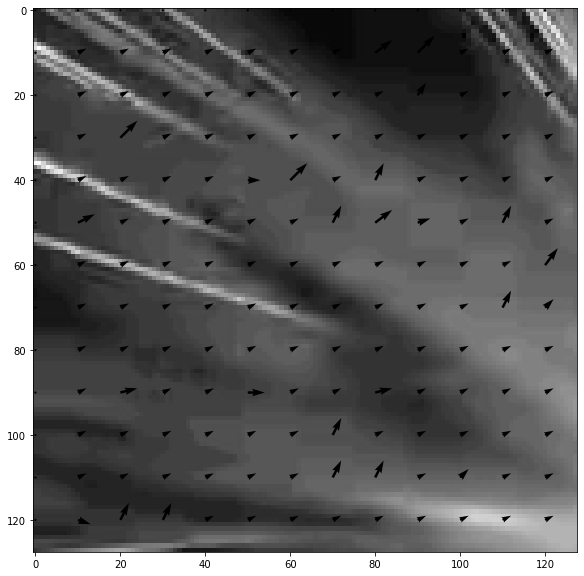

In [8]:
plt.figure(figsize=(15, 10))
plt.imshow(f1b, cmap='gray')
plt.quiver(np.arange(0, f1b.shape[1], 10), np.arange(0, f1b.shape[0], 10), fl[0, ::10, ::10], fl[1, ::10, ::10], angles='xy', scale_units='xy', scale=1.)

<ipython-input-6-f9b2c3a948e1>:22: RuntimeWarning: overflow encountered in ushort_scalars
  dist = np.sqrt((cur - f2[k, l])**2)
100% (8388608 of 8388608) |##############| Elapsed Time: 0:01:52 Time:  0:01:52


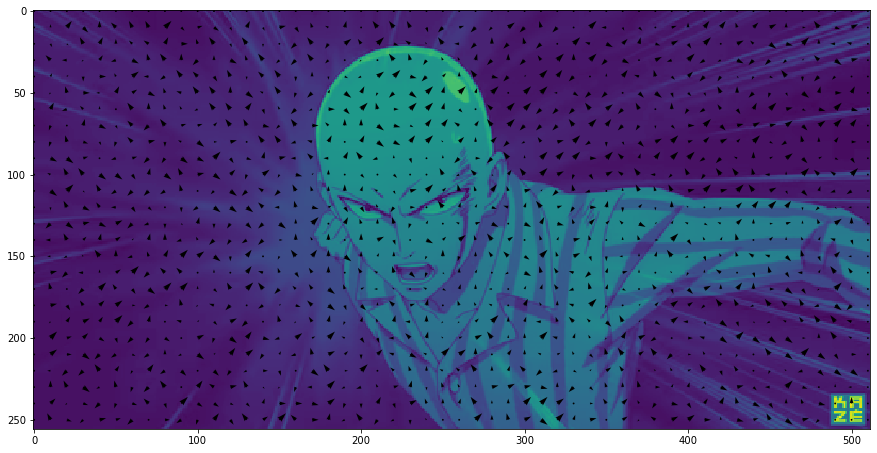

In [9]:
flow = pixel_wise(f1, f2)

plt.figure(figsize=(15, 10))

plt.imshow(f1)

plt.quiver(np.arange(0, f1.shape[1], 10), np.arange(0, f1.shape[0], 10), flow[0, ::10, ::10], flow[1, ::10, ::10], angles='xy', scale_units='xy', scale=1.)

### B - BMA

In [264]:
from skimage.filters.rank import entropy
from skimage.morphology import disk

def SSE(arr_1, arr_2):
    return np.sum((arr_1 - arr_2)**2)


def BMA(frame_1, frame_2, size_block=16, ran=5):
    flow = np.zeros(shape=(2, frame_2.shape[0], frame_2.shape[1]))
    ctn = 0
    size_block = size_block // 2
    with progressbar.ProgressBar(max_value=frame_1.shape[0] * frame_2.shape[1] * 2 * ran * ran) as bar:
        for i in range(size_block + ran // 2, frame_2.shape[0] - size_block - ran // 2):
            for j in range(size_block + ran // 2, frame_2.shape[1] - size_block - ran // 2):
                mask_f1 = frame_1[i-size_block:i+size_block, j - size_block:j + size_block]
                best = np.inf
                position = (0, 0)
                for k in range(0, ran):
                    for l in range(0, ran):
                        mask_f2 = frame_2[i-size_block + (k- (ran // 2)):i+size_block + (k- (ran // 2)), j - size_block + (l- (ran // 2)):j  + size_block + (l- (ran // 2))]
                        s = SSE(mask_f1, mask_f2)
                        if (s < best):
                            position = (k - (ran // 2), l - (ran // 2))
                            best = s
                        bar.update(ctn)
                        ctn += 1
                flow[0, i, j] = -1 * position[0]
                flow[1, i, j] = position[1]
    return flow

In [265]:
im_1 = skimage.color.rgb2gray(skimage.io.imread("metro-bleu.jpg"))
im_1.shape

(1329, 1999)

In [266]:
vxtest = 2
vytest = 0

In [267]:
f1b = f1[128:256,128:256]
f2b = f1[128+vxtest:256+vxtest,128+vytest:256+vytest]

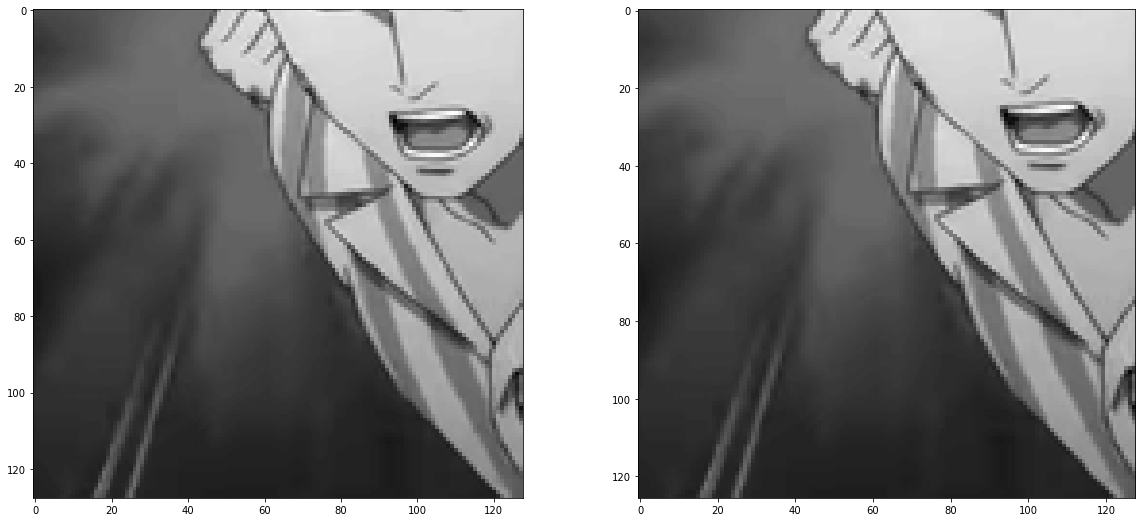

In [268]:
plt.figure(figsize=(20, 9))

plt.subplot(121)
plt.imshow(f1b, cmap='gray')

plt.subplot(122)
plt.imshow(f2b, cmap='gray')

In [269]:
flow_t = BMA(f1b, f2b)

100% (819200 of 819200) |################| Elapsed Time: 0:00:04 Time:  0:00:04


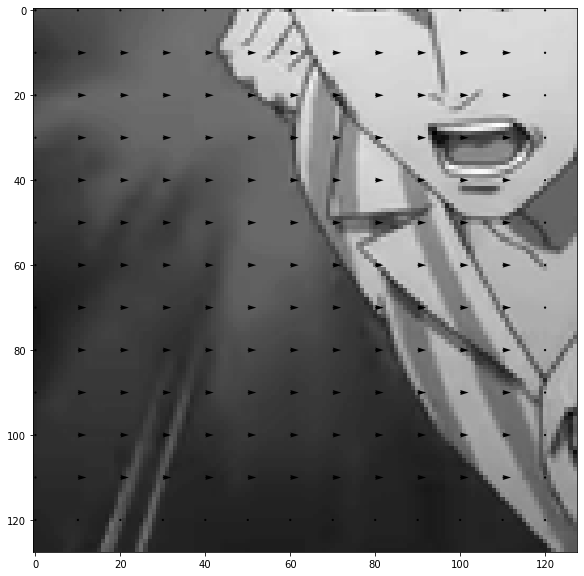

In [261]:
plt.figure(figsize=(15, 10))
plt.imshow(f1b, cmap='gray')
plt.quiver(np.arange(0, f1b.shape[1], 10), np.arange(0, f1b.shape[0], 10), flow_t[0, ::10, ::10], flow_t[1, ::10, ::10], angles='xy', scale_units='xy', scale=1.)

100% (806400 of 806400) |################| Elapsed Time: 0:00:04 Time:  0:00:04


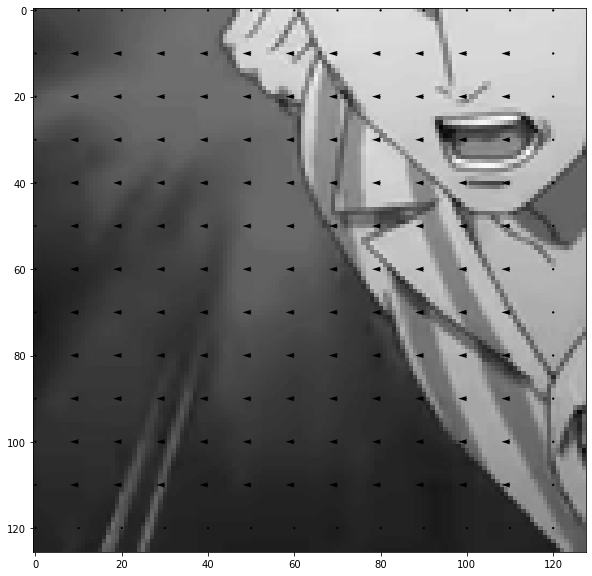

In [270]:
flow_t2 = BMA(f2b, f1b)

plt.figure(figsize=(15, 10))
plt.imshow(f2b, cmap='gray')
plt.quiver(np.arange(0, f2b.shape[1], 10), np.arange(0, f2b.shape[0], 10), flow_t2[0, ::10, ::10], flow_t2[1, ::10, ::10], angles='xy', scale_units='xy', scale=1.)

100% (6553600 of 6553600) |##############| Elapsed Time: 0:00:45 Time:  0:00:45


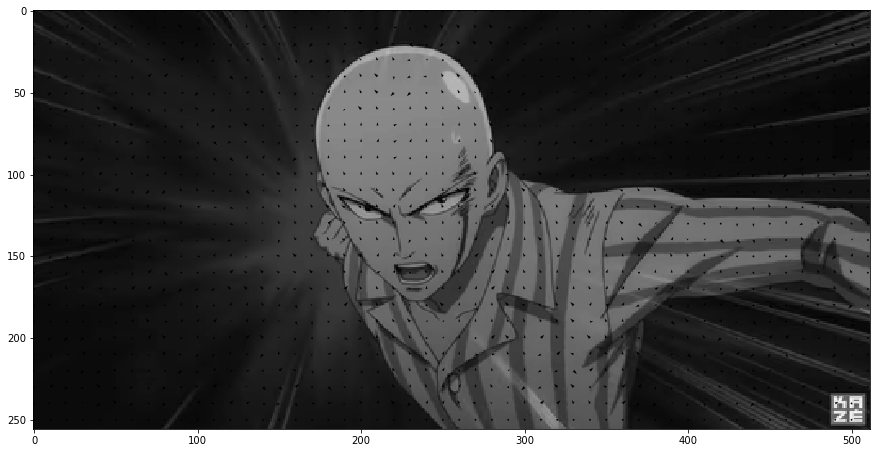

In [271]:
flow = BMA(f1, f2)

plt.figure(figsize=(15, 10))
plt.imshow(f1, cmap='gray')
plt.quiver(np.arange(0, f1.shape[1], 10), np.arange(0, f1.shape[0], 10), flow[0, ::10, ::10], flow[1, ::10, ::10], angles='xy', scale_units='xy', scale=1.)

##### C - Déduction

Par rapport à la méthode du *pixel_wise*, la méthode du *BMA* est plus précise.

## Question 2 - Motion compensation

### A - estimation du mouvement de F2 -> F1

100% (6553600 of 6553600) |##############| Elapsed Time: 0:00:40 Time:  0:00:40


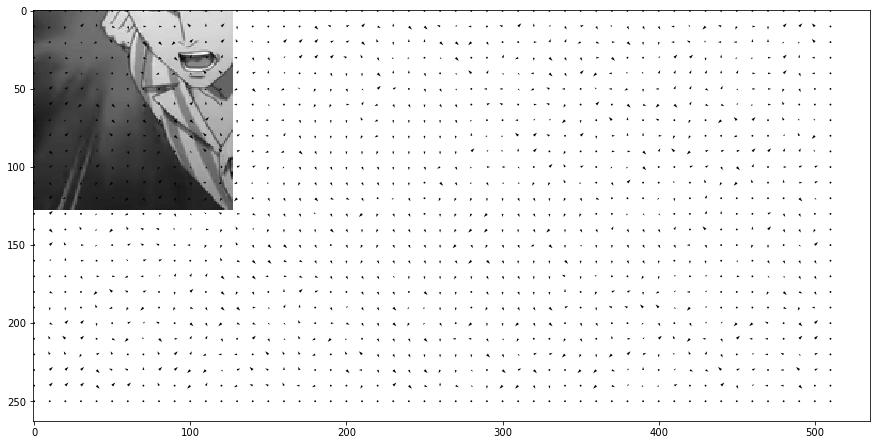

In [23]:
flow2 = BMA(f2, f1)

plt.figure(figsize=(15, 10))
plt.imshow(f1b, cmap='gray')
plt.quiver(np.arange(0, f1.shape[1], 10), np.arange(0, f1.shape[0], 10), flow2[0, ::10, ::10], flow2[1, ::10, ::10], angles='xy', scale_units='xy', scale=1.)

### C - Reconstruction de l'image F2

Reconstruction de l'image

In [20]:
def reconstruct(frame_1, estimation):
    im = frame_1.copy()
    for i in range(frame_1.shape[0]):
        for j in range(frame_1.shape[1]):
            vx, vy = estimation[0, i, j], estimation[1, i, j]
            im[int(i + vx), int(j + vy)] = frame_1[i, j]
            
    return im

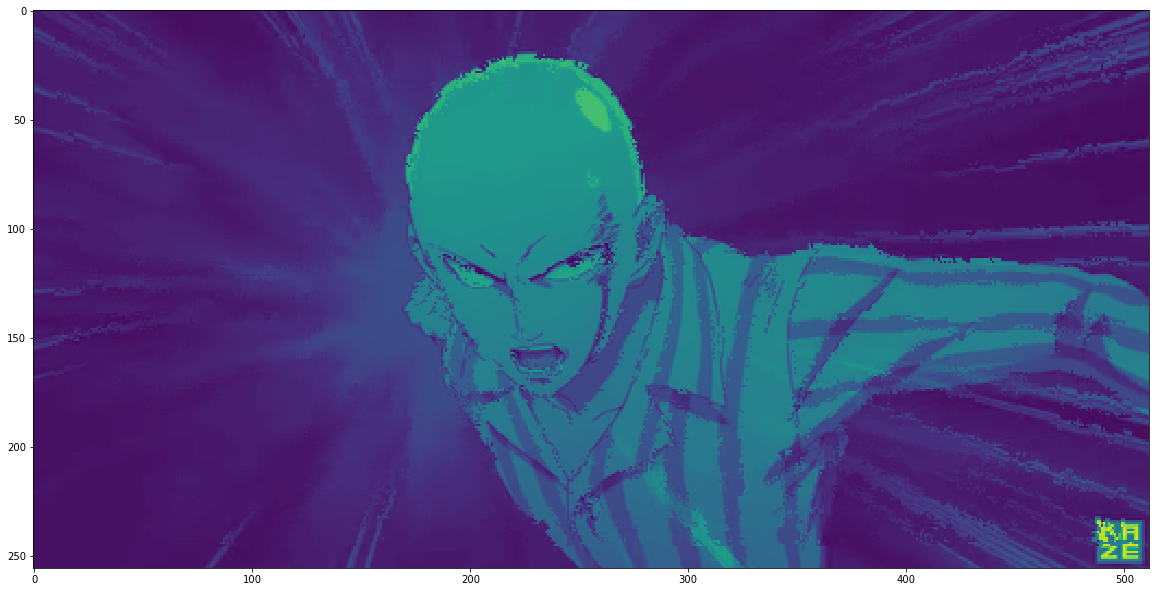

In [21]:
plt.figure(figsize=(20, 16))

plt.imshow(reconstruct(f1, flow))